## ММРО, ММП ВМК МГУ

## Семинар 3

## `sklearn` и линейная регрессия

### Автор: Оганов Александр

*часть материалов взята из [ноутбука Евгения Соколова](https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/seminars/sem02-sklearn-linregr.ipynb)*

На этом семинаре мы:
* Изучим первую модель функциональной парадигмы машинного обучения - линейную регрессию
* Узнаем как не допустить переобучения в линейных моделях;
* Обучим линейную регрессию для предсказания цены дома;
* Научимся работать с разными типами признаков;
* Поймем, в чем отличие между разными регуляризаторами;
* Научимся пользоваться основными инструментами в `sklearn`: моделями, трансформерами и pipeline;
* Обсудим преобразования признаков и целевой переменной, которые могут помочь в обучении линейных моделей.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy
import warnings
import time

from tqdm.notebook import tqdm
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [23]:
def gen(n: int, seed=42):
    np.random.seed(seed)
    X = np.random.rand(n, 1)
    
    eps = np.random.randn(n, 1)
    y = X * 5 + 42 + eps 
    return X, y


def gen_complex(n: int, d: int, seed=42):
    '''
        :param n(int): num objects
        :param d(int): features dim
    '''

    np.random.seed(seed)
    X = np.random.rand(n, d)
    
    eps = np.random.randn(n, 1)
    y = X.sum(1)[:, None] + 42 + eps 
    return X, y


def solve(X, y):
    X_new = np.hstack([X, np.ones((X.shape[0], 1))])
    # return np.linalg.inv(X_new.T @ X_new) @ (X_new.T @ y)

    return scipy.linalg.solve(
        X_new.T @ X_new, X_new.T @ y,
        assume_a='sym'
    )


def calc_metric(X, y, w):
    y_pred = X @ w[:-1] + w[-1]
    return np.mean((y - y_pred) ** 2)


def visualize(X, y, w_pred, w_true=np.array([[5], [42]])):
    x_grid = np.linspace(X.min(), X.max(), 1000)
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    
    axs[0].plot(x_grid, x_grid * w_true[0] + w_true[1], c="red", label="Истинное значение")
    axs[0].set_title(f"MSE {calc_metric(X, y, w_true):0.4f}")
    
    axs[1].plot(x_grid, x_grid * w_pred[0] + w_pred[1], c="yellow", label="Предсказанное значение")
    axs[1].set_title(f"MSE {calc_metric(X, y, w_pred):0.4f}")
    
    for i in range(2):
        axs[i].scatter(X, y)
        axs[i].legend()
        axs[i].set_xlabel("X")
        axs[i].set_ylabel("y")
        
    
    plt.show()

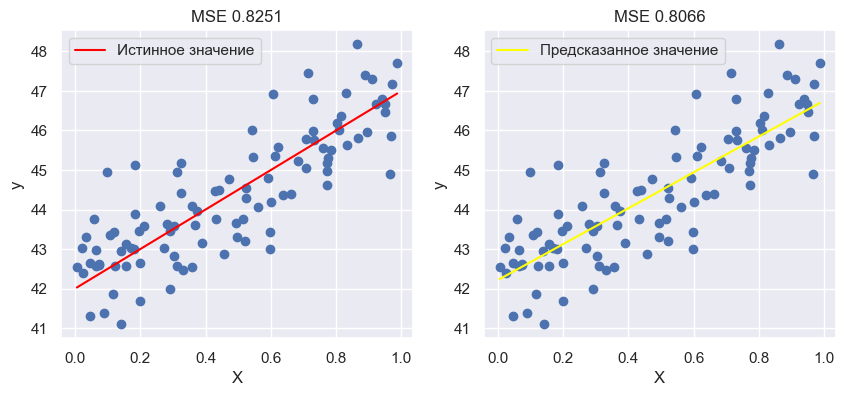

In [24]:
X, y = gen(n=100)
w = solve(X, y)
visualize(X, y, w)

Кажется, что задача решена и изучение линейных моделей можно завершить. Но не все так просто. Посмотрим на зависимость времени обучения модели от размера признакового пространства выборки.

In [ ]:
d_grid = np.linspace(1e3,  1e4, 20, dtype=int)
X_all, y_all = gen_complex(d=np.max(d_grid), n=1000)

In [ ]:
results = []
for n in tqdm(d_grid):
    X, y = X_all[:, :n], y_all[:, :n]
    t_start = time.time()
    w = solve(X, y)
    t_end = time.time()
    
    results.append(t_end - t_start)    

  0%|          | 0/20 [00:00<?, ?it/s]

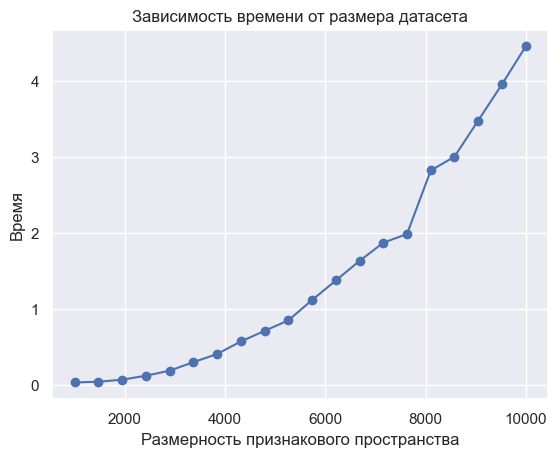

In [ ]:
plt.plot(d_grid, results)
plt.scatter(d_grid, results)
plt.title("Зависимость времени от размера датасета")
plt.xlabel("Размерность признакового пространства")
plt.ylabel("Время")
plt.show()

Какой характер зависимости?

In [28]:
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

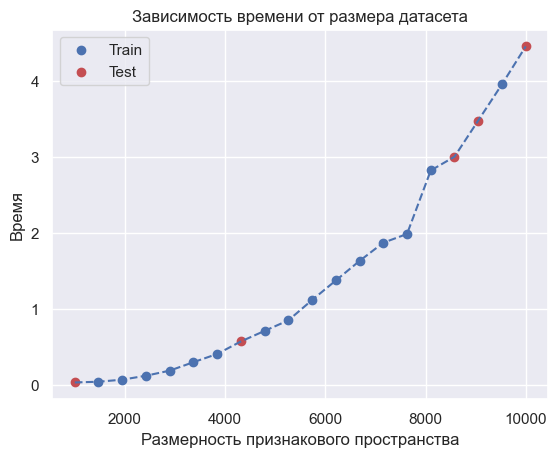

In [ ]:
results = np.array(results)

grid_train, grid_test, results_train, results_test = train_test_split(
    d_grid, results,
    test_size=0.25,
    random_state=317,
    shuffle=True
)

plt.plot(d_grid, results, '--')
plt.scatter(grid_train, results_train, c='b', label='Train')
plt.scatter(grid_test, results_test, c='r', label='Test')
plt.title("Зависимость времени от размера датасета")
plt.xlabel("Размерность признакового пространства")
plt.ylabel("Время")
plt.legend()

In [30]:
polynomial_processor = PolynomialFeatures(degree=3)
poly_train = polynomial_processor.fit_transform(grid_train.reshape((-1, 1)))
poly_test = polynomial_processor.transform(grid_test.reshape((-1, 1)))

linreg = LinearRegression()
linreg.fit(poly_train, results_train)

print(f"Train R^2: {linreg.score(poly_train, results_train)}")
print(f"Test R^2: {linreg.score(poly_test, results_test)}")

print(f"\n{linreg.coef_=}")

Train R^2: 0.9936901025997348
Test R^2: 0.9995925148532384

linreg.coef_=array([0.00000000e+00, 1.44354828e-05, 1.48324641e-08, 2.92321168e-12])


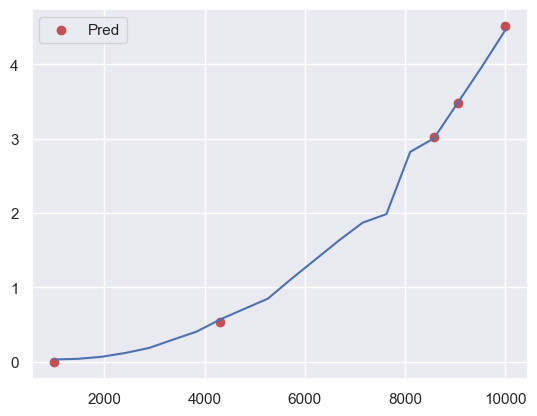

In [ ]:
plt.plot(d_grid, results)
plt.scatter(grid_test, linreg.predict(poly_test), c='r', label='Pred')

plt.legend()

Видно что зависимость кубическая. При небольших значениях, время уже ощутимое. При этом не стоит забывать что размер выборки у нас небольшой, всего 1000 объектов. Поэтому, решать задачу каждый раз аналитически не эффективно и не всегда возможно. Нужен новый алгоритм.

Посмотрим теперь на зависимость от объема выборки

In [52]:
n_grid = np.logspace(3, 5, num=20, base=10, dtype=int)
X_all, y_all = gen_complex(d=5_000, n=np.max(n_grid))

In [53]:
results = []
for n in tqdm(n_grid):
    X, y = X_all[:n, :], y_all[:n, :]
    t_start = time.time()
    w = solve(X, y)
    t_end = time.time()
    
    results.append(t_end - t_start)

  0%|          | 0/20 [00:00<?, ?it/s]

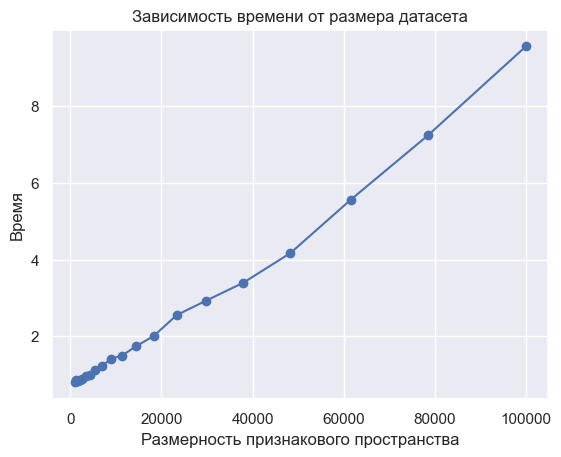

In [55]:
plt.plot(n_grid, results)
plt.scatter(n_grid, results)

# plt.xscale('log')

plt.title("Зависимость времени от размера датасета")
plt.xlabel("Размерность признакового пространства")
plt.ylabel("Время")
plt.show()

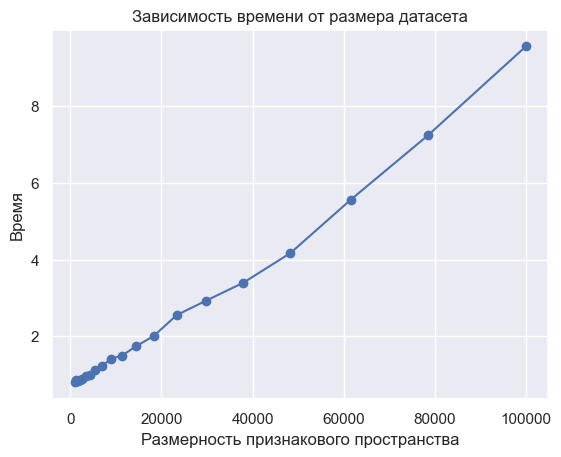

In [59]:
plt.plot(n_grid, results)
plt.scatter(n_grid, results)

# plt.xscale('log')
# plt.yscale('log')

plt.title("Зависимость времени от размера датасета")
plt.xlabel("Размерность признакового пространства")
plt.ylabel("Время")
plt.show()

### Оптимизационная задача

Посмотрим еще раз на нашу задачу

$$ J(w) = \| Xw - y \| ^2_2 \to \min_{w}$$


Для данной задачи существует крайне популярный итерационный алгоритм - Градиентный спуск/Gradient descent/GD

$$ w_{i + 1} = w_{i} - \alpha \nabla_w J(w_i)$$
$$ \nabla_w J(w) = 2X^T(Xw - y). $$

Что поменялось? Какая сложность? Куда сойдется алгоритм?

Иногда подсчитать "честный" градиент бывает сложно по времени/памяти, поэтому рассмотрим Стохастический градиентный спуск/Stochastic gradient descent/SGD

Вместо подсчета $\nabla_w J(w)$ будем использовать несмещенную оценку, то есть на каждой итерации рассматривать случайное подмножество исходного датасета

In [11]:
def get_data(X):
    return np.arange(X.shape[0])

def get_batch(X, batch_size=8):
    idx = np.random.choice(X.shape[0], batch_size, replace=False)
    return idx

def grad(X, y, w):
    return 2 * X.T @ (X @ w - y) / y.shape[0]

def grad_descent(X, y, num_steps=300, get_idx=get_data, calc_loss=True, lr=25, seed=42, eps=1e-3):
    X = np.hstack([X, np.ones((X.shape[0], 1))])
    np.random.seed(seed)
    w = np.random.randn(X.shape[1], 1)
    history = []
    for i in range(1, num_steps + 1):
        idx = get_idx(X)
        g = grad(X[idx], y[idx], w) 
        w_new = w - min(lr / i, 100) * g / np.linalg.norm(g)
        if np.linalg.norm(w_new - w) < eps:
            break
            
        w = w_new
        if calc_loss:
            loss = calc_metric(X[:, :-1], y, w)
            history.append(loss)
    return history, w

def visualize_history(history, title):
    k = 200
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].plot(history)
    axs[1].plot(np.arange(len(history) - k, len(history)), history[-k:])
    axs[0].set_ylabel("MSE")
    axs[0].set_xlabel("Номер итерации")
    fig.suptitle(title)
    plt.show()

In [12]:
X, y = gen(100)

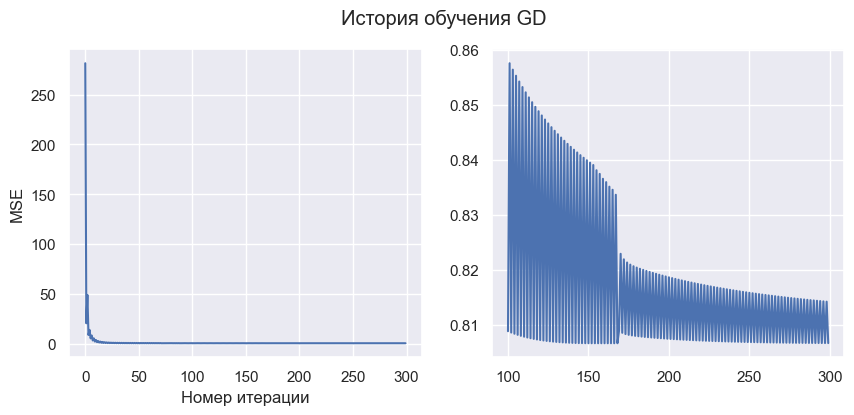

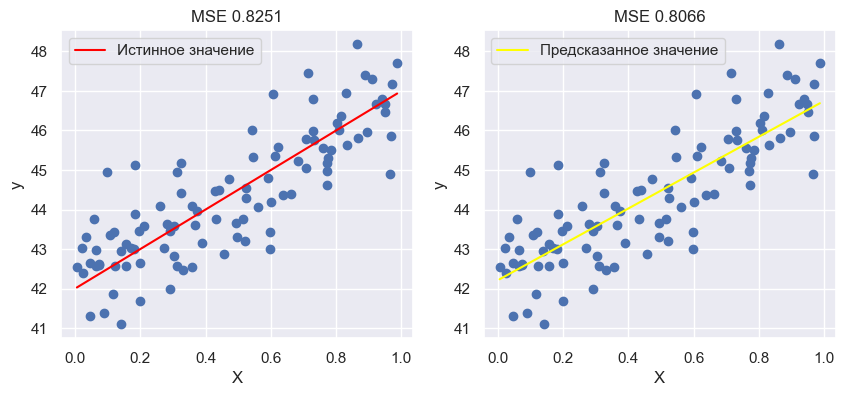

In [13]:
history, w = grad_descent(X, y)

visualize_history(history, "История обучения GD")
visualize(X, y, w)

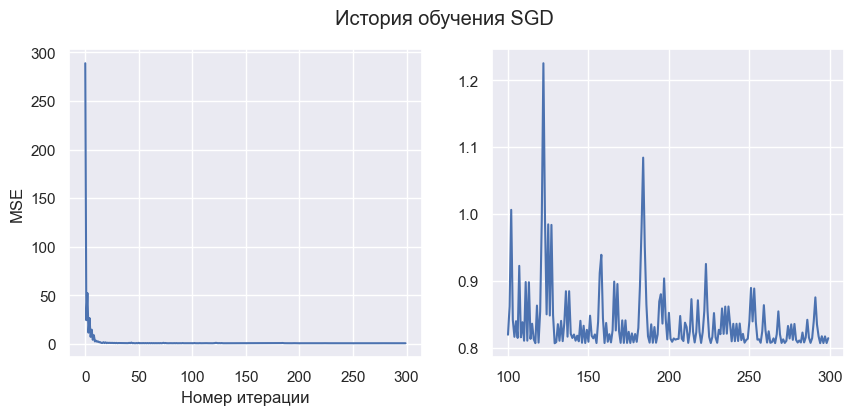

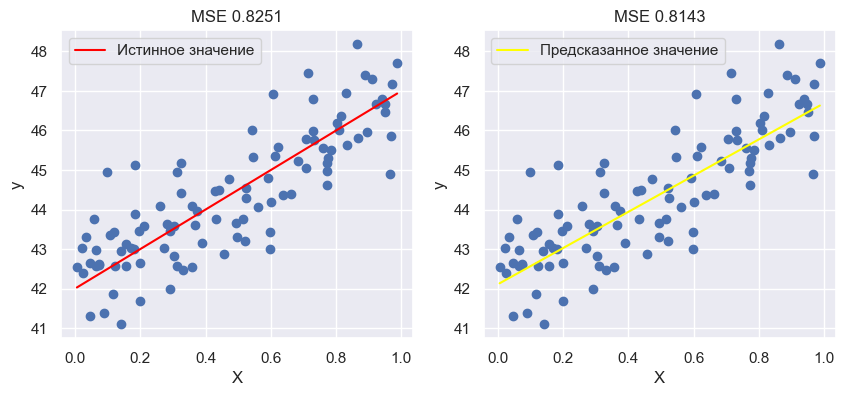

In [14]:
history, w = grad_descent(X, y, get_idx=get_batch)

visualize_history(history, "История обучения SGD")
visualize(X, y, w)

In [15]:
t_start = time.time()
history, w = grad_descent(X_all, y_all, get_idx=get_batch, num_steps=2000, calc_loss=False, lr=40)
t_end = time.time()

print(f"Время работы: {t_end - t_start:0.4f}")

Время работы: 0.1428


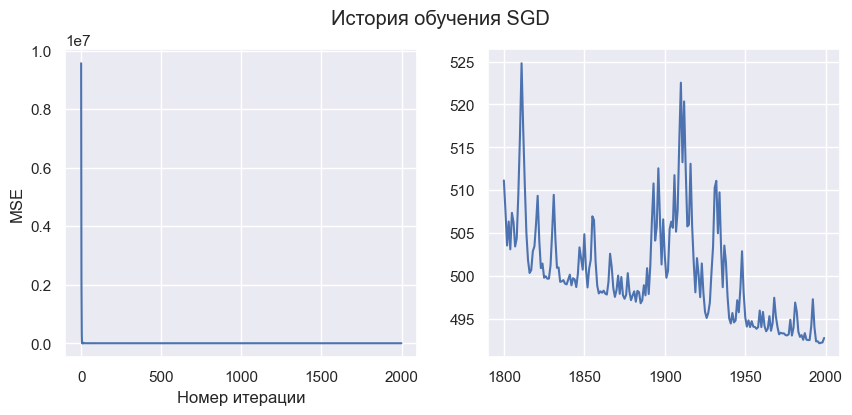

In [16]:
history, w = grad_descent(X_all, y_all, get_idx=get_batch, num_steps=2000, lr=40)

visualize_history(history, "История обучения SGD")

Используется ли градиентный спуск на практике? Какие предположения про функцию мы сделали? Какие ещё, возможно более сложные, методы оптимизации вы знаете?

Для дальнейшего чтения [L-BFGS](https://habr.com/ru/articles/333356/), [реализации различных методов scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize)

Теперь посмотрим пример применения линейной модели к реальным данным.

# Часть 1. Загружаем данные

Мы будем работать с данными из соревнования [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview), в котором требовалось предсказать стоимость жилья. Давайте сначала загрузим и немного изучим данные (можно взять `train.csv` со страницы соревнования и переименовать в `train_sem2.csv`).

In [17]:
! wget  -O 'train_sem2.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [18]:
data = pd.read_csv("train_sem2.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [19]:
data.shape

(1460, 81)

In [20]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Первое, что стоит заметить &mdash; у нас в данных есть уникальное для каждого объекта поле id. Обычно такие поля только мешают и способствуют переобучению. Удалим это поле из данных.

Разделим данные на обучающую и тестовую выборки. Для простоты не будем выделять дополнительно валидационную выборку (хотя это обычно стоит делать, она нужна для подбора гиперпараметров модели, то есть параметров, которые нельзя подбирать по обучающей выборке). Дополнительно нам придется отделить значения целевой переменной от данных.

**Вопрос 1**: Почему поля типа id могут вызвать переобучение модели (не обязательно линейной)?

**Вопрос 2**: Почему стоит дополнительно отделять валидационную выборку?

**Вопрос 3**: Обратите внимание на фиксацию `random_state` при сплите данных. Почему это важно?

In [21]:
from sklearn.model_selection import train_test_split

data = data.drop(columns=["Id"])

y = data["SalePrice"]
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

Посмотрим сначала на значения целевой переменной.

<Axes: xlabel='SalePrice', ylabel='Density'>

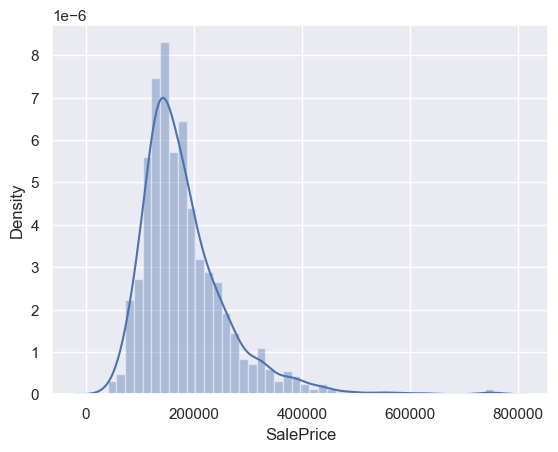

In [22]:
sns.distplot(y_train)

Судя по гистограмме, у нас есть примеры с нетипично большой стоимостью, что может помешать нам, если наша функция потерь слишком чувствительна к выбросам. В дальнейшем мы рассмотрим способы, как минимизировать ущерб от этого.

Так как для решения нашей задачи мы бы хотели обучить линейную регрессию, было бы хорошо найти признаки, "наиболее линейно" связанные с целевой переменной, иначе говоря, посмотреть на коэффициент корреляции Пирсона между признаками и целевой переменной. Заметим, что не все признаки являются числовыми, пока что мы не будем рассматривать такие признаки.

**Вопрос**: Что означает, что коэффициент корреляции Пирсона между двумя случайными величинами равен 1? -1? 0?

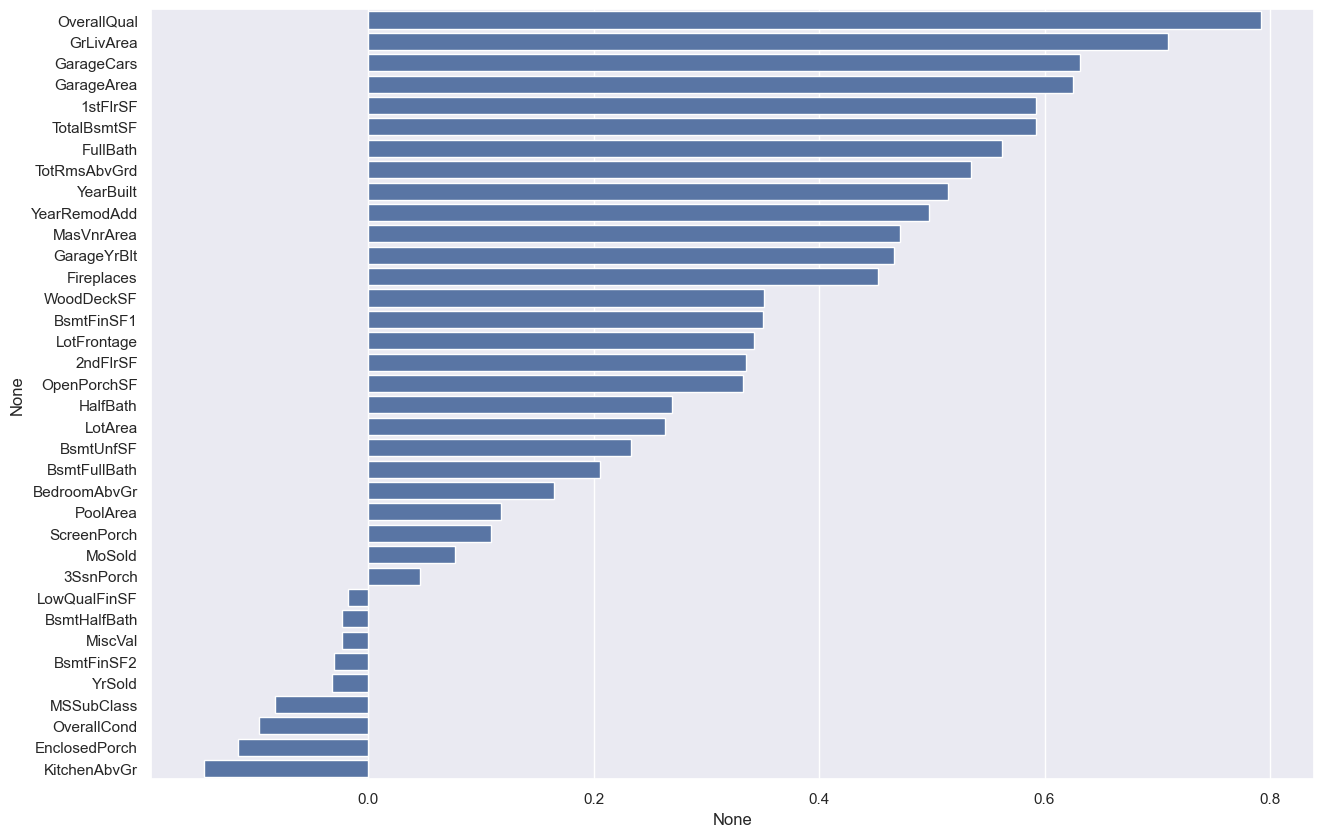

In [23]:
numeric_data = X_train.select_dtypes([np.number])
numeric_data_mean = numeric_data.mean()
numeric_features = numeric_data.columns

X_train = X_train.fillna(numeric_data_mean)
X_test = X_test.fillna(numeric_data_mean)

correlations = X_train[numeric_features].corrwith(y_train).sort_values(ascending=False)


plot = sns.barplot(y=correlations.index, x=correlations)
plot.figure.set_size_inches(15, 10)

Посмотрим на признаки из начала списка. Для этого нарисуем график зависимости целевой переменной от каждого из признаков. На этом графике каждая точка соответствует паре признак-таргет (такие графики называются scatter-plot).

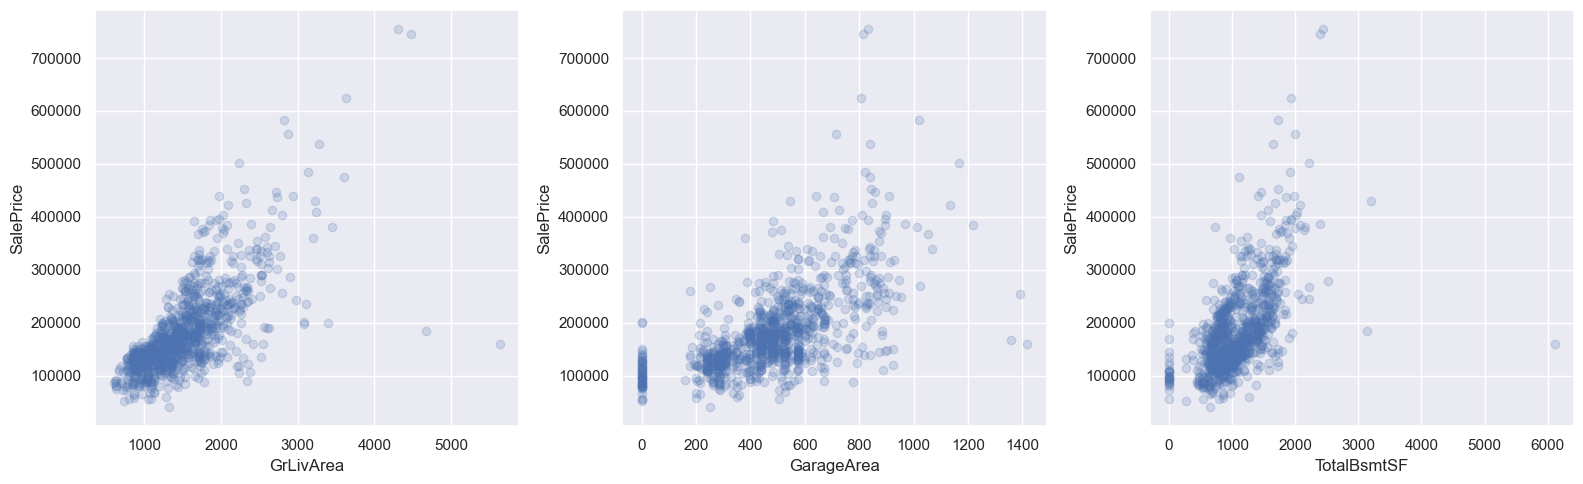

In [24]:
fig, axs = plt.subplots(figsize=(16, 5), ncols=3)
for i, feature in enumerate(["GrLivArea", "GarageArea", "TotalBsmtSF"]):
    axs[i].scatter(X_train[feature], y_train, alpha=0.2)
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel("SalePrice")
plt.tight_layout()

Видим, что между этими признаками и целевой переменной действительно наблюдается линейная зависимость.

# Часть 2. Первая модель

*Немного об обучении моделей*. В арсенале дата-саентиста кроме `pandas` и `matplotlib` должны быть библиотеки, позволяющие обучать модели. Для простых моделей (линейные модели, решающее дерево, ...) отлично подходит `sklearn`: в нем очень понятный и простой интерфейс. Несмотря на то, что в `sklearn` есть реализация бустинга и простых нейронных сетей, ими все же не пользуются и предпочитают специализированные библиотеки: `XGBoost`, `LightGBM` и пр. для градиентного бустинга над деревьями, `PyTorch`, `Tensorflow` и пр. для нейронных сетей. Так как мы будем обучать линейную регрессию, нам подойдет реализация из `sklearn`.

Попробуем обучить линейную регрессию на числовых признаках из нашего датасета. В `sklearn` есть несколько классов, реализующих линейную регрессию:
* [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) &mdash; "классическая" линейная регрессия с оптимизацией MSE. Веса находятся как точное решение: $w^* = (X^TX)^{-1}X^Ty$
* [`Ridge`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_2$-регуляризацией
* [`Lasso`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) &mdash; линейная регрессия с оптимизацией MSE и $\ell_1$-регуляризацией

У моделей из `sklearn` есть методы `fit` и `predict`. Первый принимает на вход обучающую выборку и вектор целевых переменных и обучает модель, второй, будучи вызванным после обучения модели, возвращает предсказание на выборке. Попробуем обучить нашу первую модель на числовых признаках, которые у нас сейчас есть:

In [25]:
from sklearn.linear_model import Ridge, LinearRegression

from sklearn.metrics import mean_squared_error, root_mean_squared_error

np.random.seed(36)

model = Ridge()
model.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
y_train_pred = model.predict(X_train[numeric_features])

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test RMSE = 32085.7681
Train RMSE = 35631.3131


Мы обучили первую модель и даже посчитали ее качество на отложенной выборке! Давайте теперь посмотрим на то, как можно оценить качество модели с помощью кросс-валидации. Принцип кросс-валидации изображен на рисунке

<img src="./img/cv.png" width=50%>

При кросс-валидации мы делим обучающую выборку на $n$ частей (fold). Затем мы обучаем $n$ моделей: каждая модель обучается при отсутствии соответствующего фолда, то есть $i$-ая модель обучается на всей обучающей выборке, кроме объектов, которые попали в $i$-ый фолд (out-of-fold). Затем мы измеряем качество $i$-ой модели на $i$-ом фолде. Так как он не участвовал в обучении этой модели, мы получим "честный результат". После этого, для получения финального значения метрики качества, мы можем усреднить полученные нами $n$ значений.

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring="neg_root_mean_squared_error")
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV MSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV MSE = 40156.3616


Обратите внимание на то, что результаты `cv_scores` получились отрицательными. Это соглашение в `sklearn` (скоринговую функцию нужно максимизировать). Поэтому все стандартные скореры называются `neg_*`, например, `neg_root_mean_squared_error`.

Обратите внимание, что по отложенной выборке и при кросс-валидации мы считаем RMSE (Root Mean Squared Error), хотя в функционале ошибки при обучении модели используется MSE.

$$\text{RMSE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} (y_i - a(x_i))^2}$$

**Вопрос**: Почему оптимизация RMSE эквивалентна оптимизации MSE?

Если бы RMSE не входил в стандартные метрики `sklearn`, можно было бы его определить через функцию `sklearn.metrics.make_scorer`.

In [27]:
from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

In [28]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train[numeric_features], y_train, cv=10, scoring=rmse_scorer)
print("Cross validation scores:\n\t", "\n\t".join("%.4f" % x for x in cv_scores))
print("Mean CV RMSE = %.4f" % np.mean(-cv_scores))

Cross validation scores:
	 -38825.3172
	-45278.9230
	-31405.3380
	-33890.1048
	-73848.3061
	-24142.7915
	-45523.7066
	-52861.2908
	-26094.3376
	-29693.5005
Mean CV RMSE = 40156.3616


Для того, чтобы иметь некоторую точку отсчета, удобно посчитать оптимальное значение функции потерь при константном предсказании.

**Вопрос**: Чему равна оптимальная константа для RMSE?

In [29]:
best_constant = y_train.mean()
print("Test RMSE with best constant = %.4f" % root_mean_squared_error(y_test, best_constant * np.ones(y_test.shape)))
print("Train RMSE with best constant = %.4f" % root_mean_squared_error(y_train, best_constant * np.ones(y_train.shape)))

Test RMSE with best constant = 76636.5188
Train RMSE with best constant = 80588.6191


Давайте посмотрим на то, какие же признаки оказались самыми "сильными". Для этого визуализируем веса, соответствующие признакам. Чем больше вес &mdash; тем более сильным является признак.

**Вопрос**: Почему это не совсем правда?

In [30]:
def show_weights(features, weights, scales):
    fig, axs = plt.subplots(figsize=(14, 10), ncols=2)
    sorted_weights = sorted(zip(weights, features, scales), reverse=True)
    weights = [x[0] for x in sorted_weights]
    features = [x[1] for x in sorted_weights]
    scales = [x[2] for x in sorted_weights]
    sns.barplot(y=features, x=weights, ax=axs[0])
    axs[0].set_xlabel("Weight")
    sns.barplot(y=features, x=scales, ax=axs[1])
    axs[1].set_xlabel("Scale")
    plt.tight_layout()

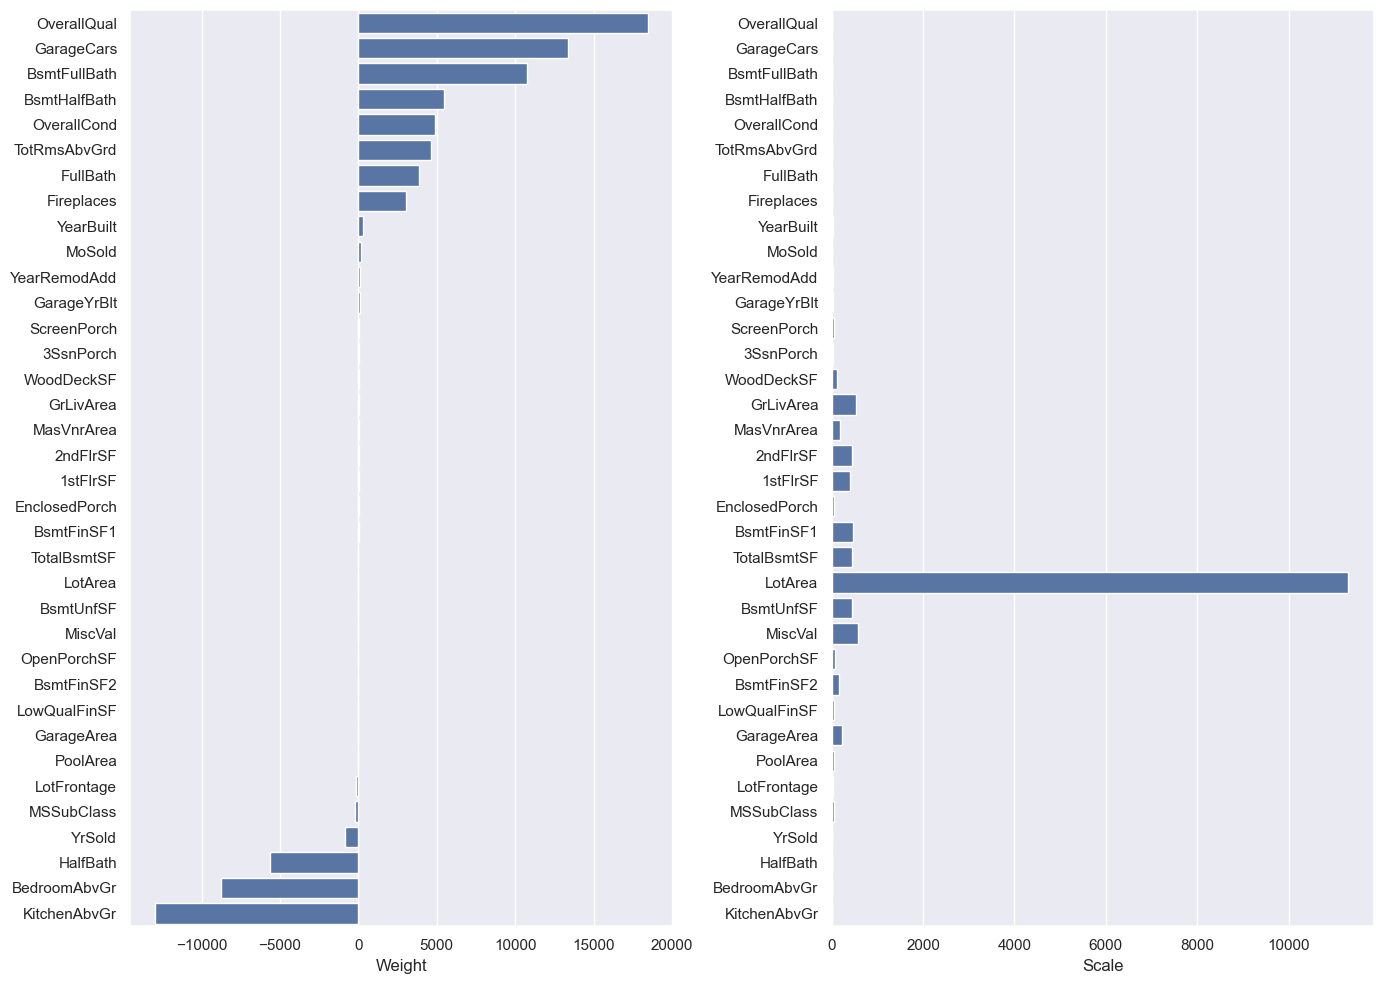

In [31]:
show_weights(numeric_features, model.coef_, X_train[numeric_features].std())

Будем масштабировать наши признаки перед обучением модели. Это, среди, прочего, сделает нашу регуляризацию более честной: теперь все признаки будут регуляризоваться в равной степени. 

Для этого воспользуемся трансформером [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). Трансформеры в `sklearn` имеют методы `fit` и `transform` (а еще `fit_transform`). Метод `fit` принимает на вход обучающую выборку и считает по ней необходимые значения (например статистики, как `StandardScaler`: среднее и стандартное отклонение каждого из признаков). `transform` применяет преобразование к переданной выборке.

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

model = Ridge()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
y_train_pred = model.predict(X_train_scaled)

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))
print("Train RMSE = %.4f" % root_mean_squared_error(y_train, y_train_pred))

Test RMSE = 32085.3150
Train RMSE = 35631.2160


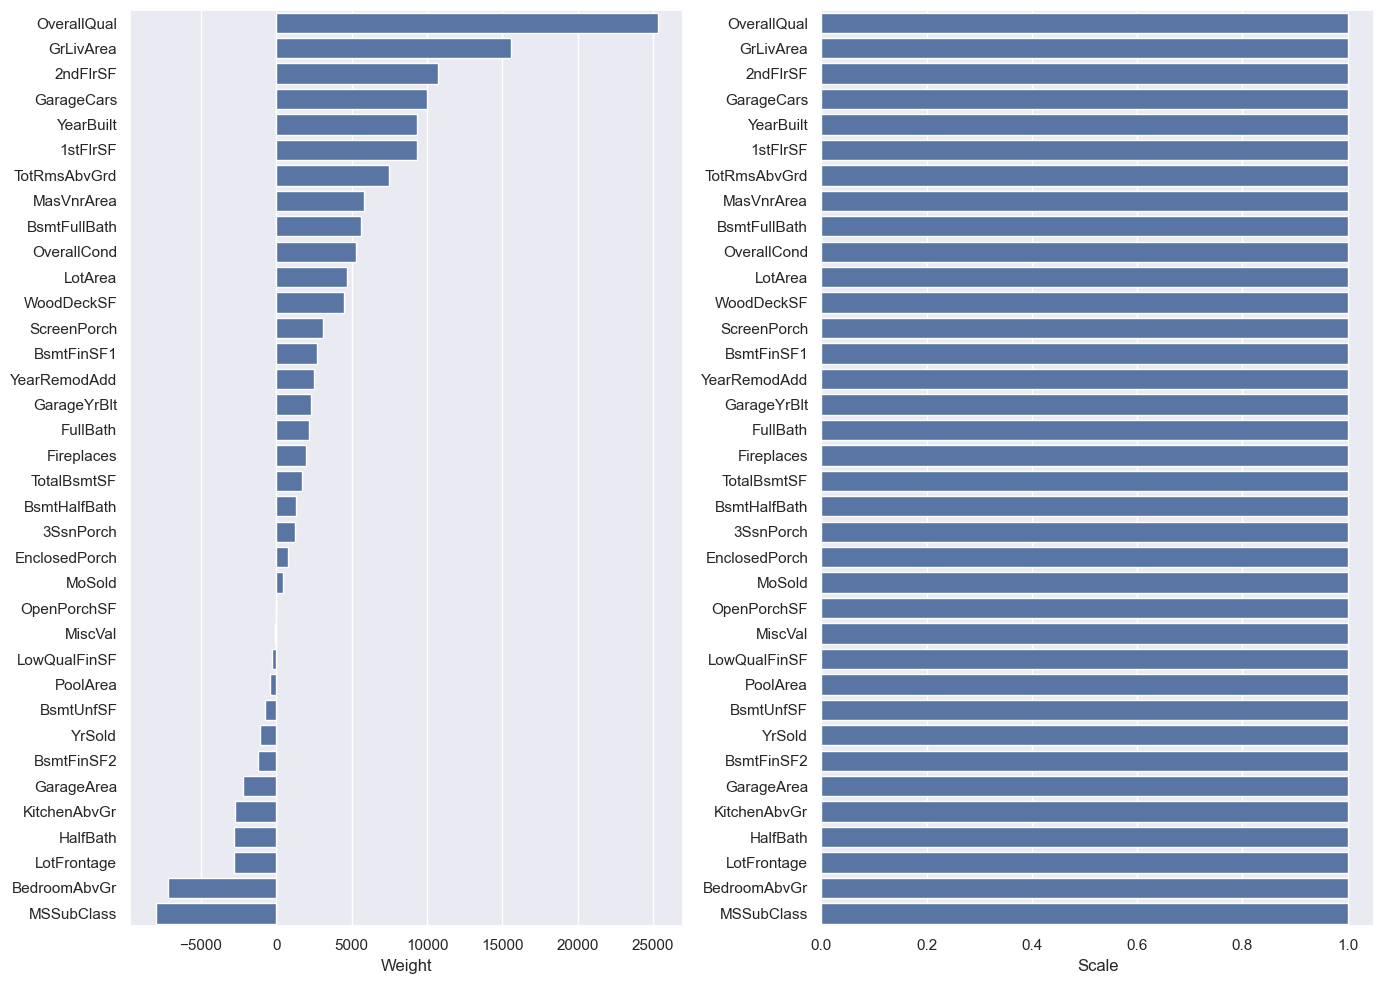

In [34]:
scales = pd.Series(data=X_train_scaled.std(axis=0), index=numeric_features)
show_weights(numeric_features, model.coef_, scales)

Наряду с параметрами (веса $w$, $w_0$), которые модель оптимизирует на этапе обучения, у модели есть и гиперпараметры. У нашей модели это `alpha` &mdash; коэффициент регуляризации. Подбирают его обычно по сетке, измеряя качество на валидационной (не тестовой) выборке или с помощью кросс-валидации. Посмотрим, как это можно сделать (заметьте, что мы перебираем `alpha` по логарифмической сетке, чтобы узнать оптимальный порядок величины).

Best alpha = 297.6351


Text(0, 0.5, 'CV score')

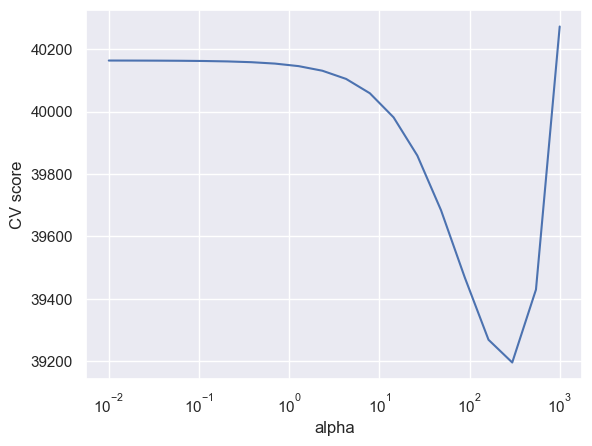

In [35]:
from sklearn.model_selection import GridSearchCV

alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(Ridge(), [{"alpha": alphas}], scoring="neg_root_mean_squared_error", cv=10)
searcher.fit(X_train_scaled, y_train)

best_alpha = searcher.best_params_["alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

**Вопрос**: Почему мы не подбираем коэффициент регуляризации по обучающей выборке? По тестовой выборке?

Попробуем обучить модель с подобранным коэффициентом регуляризации. Заодно воспользуемся очень удобным классом [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): обучение модели часто представляется как последовательность некоторых действий с обучающей и тестовой выборками (например, сначала нужно отмасштабировать выборку (причем для обучающей выборки нужно применить метод `fit`, а для тестовой &mdash; `transform`), а затем обучить/применить модель (для обучающей `fit`, а для тестовой &mdash; `predict`). `Pipeline` позволяет хранить эту последовательность шагов и корректно обрабатывает разные типы выборок: и обучающую, и тестовую.

In [36]:
from sklearn.pipeline import Pipeline

simple_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('regression', Ridge(best_alpha))
])

model = simple_pipeline.fit(X_train[numeric_features], y_train)
y_pred = model.predict(X_test[numeric_features])
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 31703.3590


# Часть 3. Работаем с категориальными признаками

Сейчас мы явно вытягиваем из данных не всю информацию, что у нас есть, просто потому, что мы не используем часть признаков. Эти признаки в датасете закодированы строками, каждый из них обозначает некоторую категорию. Такие признаки называются категориальными. Давайте выделим такие признаки и сразу заполним пропуски в них специальным значением (то, что у признака пропущено значение, само по себе может быть хорошим признаком).

In [37]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
X_train[categorical] = X_train[categorical].fillna("NotGiven")
X_test[categorical] = X_test[categorical].fillna("NotGiven")

In [38]:
X_train[categorical].sample(5)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
1274,RL,Pave,NotGiven,Reg,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
103,RL,Pave,NotGiven,IR1,Lvl,AllPub,Corner,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
149,RM,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,...,Detchd,Unf,Fa,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
96,RL,Pave,NotGiven,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NotGiven,NotGiven,NotGiven,WD,Normal
771,RL,Pave,NotGiven,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,Detchd,Unf,TA,TA,Y,NotGiven,NotGiven,NotGiven,COD,Normal


Сейчас нам нужно как-то закодировать эти категориальные признаки числами, ведь линейная модель не может работать с такими абстракциями. Два стандартных трансформера из `sklearn` для работы с категориальными признаками &mdash; [`OrdinalEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) (просто перенумеровывает значения признака натуральными числами) и [`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

`OneHotEncoder` ставит в соответствие каждому признаку целый вектор, состоящий из нулей и одной единицы (которая стоит на месте, соответствующем принимаемому значению, таким образом кодируя его).

**Вопрос**: Проинтерпретируйте, что означают веса модели перед OneHot-кодированными признаками. Почему пользоваться `OrdinalEncoder` в случае линейной модели &mdash; скорее плохой вариант? Какие недостатки есть у OneHot-кодирования?

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 26064.7187


**Вопрос**: Как вы думаете, почему мы не производим скейлинг OneHot-кодированных признаков?

Посмотрим на размеры матрицы после OneHot-кодирования:

In [40]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (1022, 79)
Size after OneHot: (1022, 293)


Как видим, количество признаков увеличилось более, чем в 3 раза. Это может повысить риски переобучиться: соотношение количества объектов к количеству признаков сильно сократилось.

Попытаемся обучить линейную регрессию с $\ell_1$-регуляризатором. На лекциях вы узнаете, что $\ell_1$-регуляризатор разреживает признаковое пространство, иными словами, такая модель зануляет часть весов.

In [41]:
from sklearn.linear_model import Lasso

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = lasso_pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

RMSE = 26446.6016


In [42]:
ridge_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
lasso_zeros = np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Ridge:", ridge_zeros)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Ridge: 0
Zero weights in Lasso: 31


Подберем для нашей модели оптимальный коэффициент регуляризации. Обратите внимание, как перебираются параметры у `Pipeline`.

In [43]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

Best alpha = 263.6651


Text(0, 0.5, 'CV score')

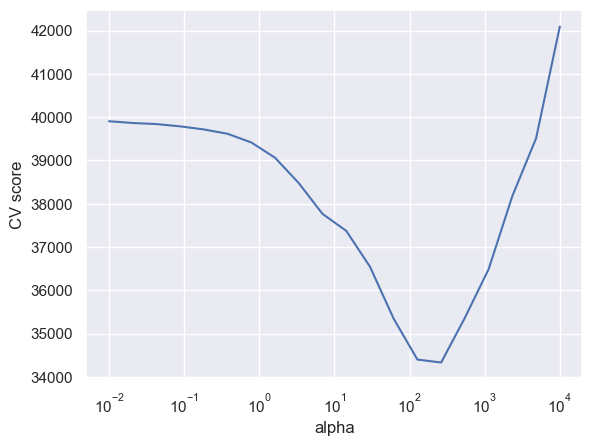

In [44]:
alphas = np.logspace(-2, 4, 20)
searcher = GridSearchCV(lasso_pipeline, [{"regression__alpha": alphas}],
                        scoring="neg_root_mean_squared_error", cv=10, n_jobs=-1)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [45]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 25645.3918


In [46]:
lasso_zeros = np.sum(pipeline.steps[-1][-1].coef_ == 0)
print("Zero weights in Lasso:", lasso_zeros)

Zero weights in Lasso: 217


Иногда очень полезно посмотреть на распределение остатков. Нарисуем гистограмму распределения квадратичной ошибки на обучающих объектах:

<Axes: xlabel='error', ylabel='Density'>

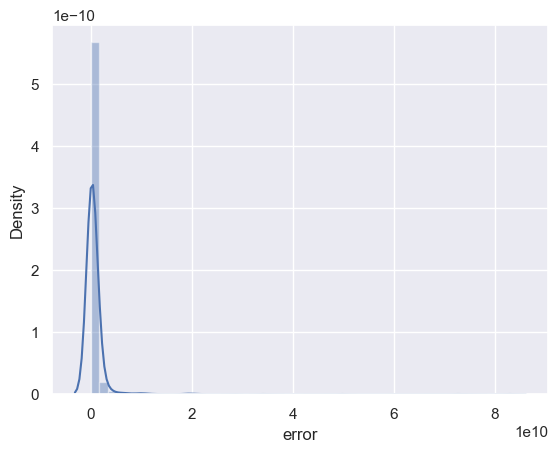

In [47]:
error = (y_train - model.predict(X_train)) ** 2
sns.distplot(error, axlabel="error")

Как видно из гистограммы, есть примеры с очень большими остатками. Попробуем их выбросить из обучающей выборки. Например, выбросим примеры, остаток у которых больше 0.95-квантили.

In [48]:
mask = (error < np.quantile(error, 0.95))

In [49]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha))
])

model = pipeline.fit(X_train[mask], y_train[mask])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 24963.5948


In [50]:
X_train = X_train[mask]
y_train = y_train[mask]

<Axes: xlabel='error', ylabel='Density'>

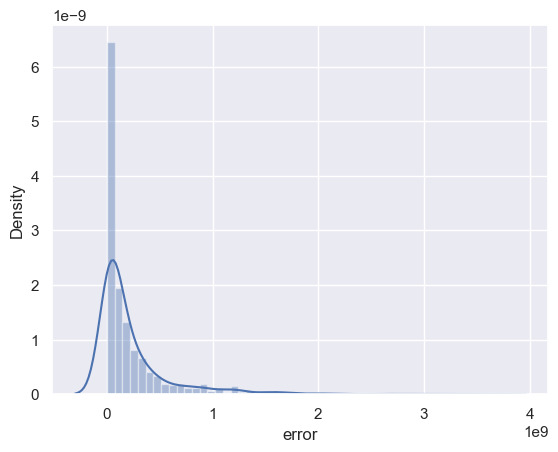

In [51]:
error = (y_train[mask] - model.predict(X_train[mask])) ** 2
sns.distplot(error, axlabel="error")

Видим, что качество модели заметно улучшилось! Также бывает очень полезно посмотреть на примеры с большими остатками и попытаться понять, почему же модель на них так сильно ошибается: это может дать понимание, как модель можно улучшить.

# Часть 4. Подготовка данных для линейных моделей

Есть важное понятие, связанное с применением линейных моделей, — *спрямляющее пространство*. Под ним понимается такое признаковое пространство для наших объектов, в котором линейная модель хорошо описывает данные, даёт хорошее качество прогнозов.

Не существует общих рекомендаций о том, как найти спрямляющее пространство для произвольной выборки. Есть лишь некоторые общие советы — например, если добавить в выборку полиномиальных признаков, то скорее всего модель станет работать лучше (если не переобучится).

У линейных моделей есть огромное преимущество: они имеют мало параметров, а поэтому их можно обучить даже на небольшой выборке. Если выборка большая, то параметры модели получится оценить более надёжно — но в то же время есть риск, что данные будут слишком разнообразными, чтобы линейная модель могла уловить все закономерности в них. Иногда можно улучшить ситуацию путём разбиения признакового пространства на несколько областей и построения своей модели в каждой из них.

Попробуем для примера в нашей задаче разделить выборку на две части по признаку OverallQual. Это один из самых сильных признаков, и, возможно, разбиение по нему даст нам две выборки с заведомо разными ценами на дома.

Для начала вспомним, какое качество получается у обычной гребневой регрессии.

In [52]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 23430.2159


Посмотрим на связь OverallQual и целевой переменной.

Text(0, 0.5, 'SalePrice')

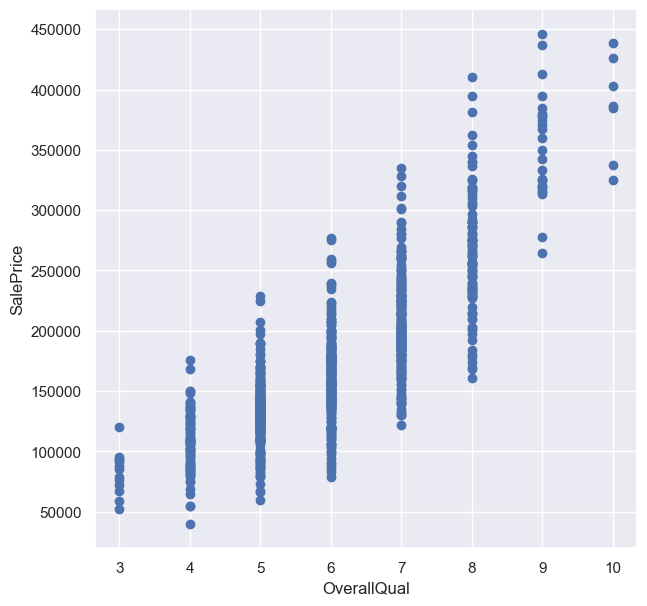

In [53]:
plt.figure(figsize=(7, 7))
plt.scatter(X_train.OverallQual, y_train)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')

In [54]:
threshold = 5
mask = (X_train.OverallQual <= threshold)
X_train_1 = X_train[mask]
y_train_1 = y_train[mask]
X_train_2 = X_train[~mask]
y_train_2 = y_train[~mask]

In [55]:
column_transformer1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline1 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer1),
    ('regression', Ridge())
])

column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', Ridge())
])



model1 = pipeline1.fit(X_train_1, y_train_1)
model2 = pipeline2.fit(X_train_2, y_train_2)

y_pred_1 = model1.predict(X_test)
y_pred_2 = model2.predict(X_test)
mask_test = (X_test.OverallQual <= threshold)
y_pred = y_pred_1.copy()
y_pred[~mask_test] = y_pred_2[~mask_test]

print("Test RMSE = %.4f" % root_mean_squared_error(y_test, y_pred))

Test RMSE = 22594.5606


Получилось лучше! И это при практически случайном выборе разбиения. Если бы мы поработали над этим получше, то и качество, скорее всего, получилось бы выше.

Перейдём к следующему трюку — бинаризации признаков. Мы выбираем $n$ порогов $t_1, \dots, t_n$ для признака~$x_j$ и генерируем $n+1$ новый признак: $[x_j \leq t_1], [t_1 < x_j \leq t_2], \dots, [t_{n-1} < x_j \leq t_n], [x_j > t_n]$. Такое преобразование может неплохо помочь в случае, если целевая переменная нелинейно зависит от одного из признаков. Рассмотрим синтетический пример.

In [56]:
from sklearn.preprocessing import KBinsDiscretizer

(-2.0, 2.0)

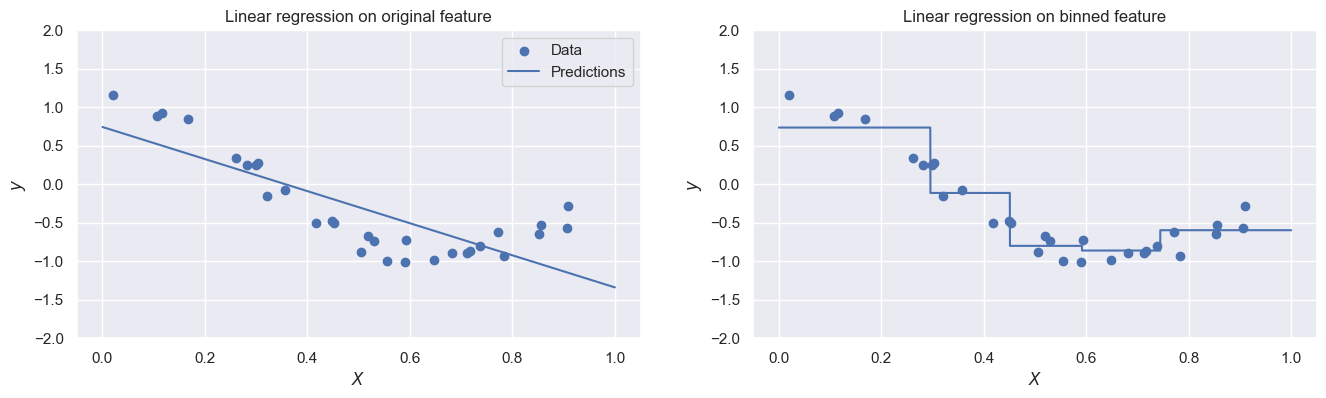

In [57]:
x_plot = np.linspace(0, 1, 10000)

X = np.random.uniform(0, 1, size=30)
y = np.cos(1.5 * np.pi * X) + np.random.normal(scale=0.1, size=X.shape)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original feature")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")
axs[0].set_ylim(-2, 2)

binner = KBinsDiscretizer(n_bins=5, strategy='quantile')
pipeline = Pipeline(steps=[
    ('binning', binner),
    ('regression', LinearRegression())
])
pipeline.fit(X[:, np.newaxis], y)
y_pred_binned = pipeline.predict(x_plot[:, np.newaxis])
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_binned, label="Predictions")
axs[1].set_title("Linear regression on binned feature")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")
axs[1].set_ylim(-2, 2)

Видно, что качество модели существенно возрасло. С другой стороны, увеличилось и количество параметров модели (из-за увеличения числа признаков), поэтому при бинаризации важно контролировать переобучение.

Иногда может помочь преобразование целевой переменной. Может оказаться, что по мере роста признаков целевая переменная меняется экспоненциально. Например, может оказаться, что при линейном уменьшении продолжительности видео число его просмотров растёт экспоненциально. Учеть это можно с помощью логарифмирования целевой переменной — ниже синтетический пример с такой ситуацией.

Text(0, 0.5, '$y$')

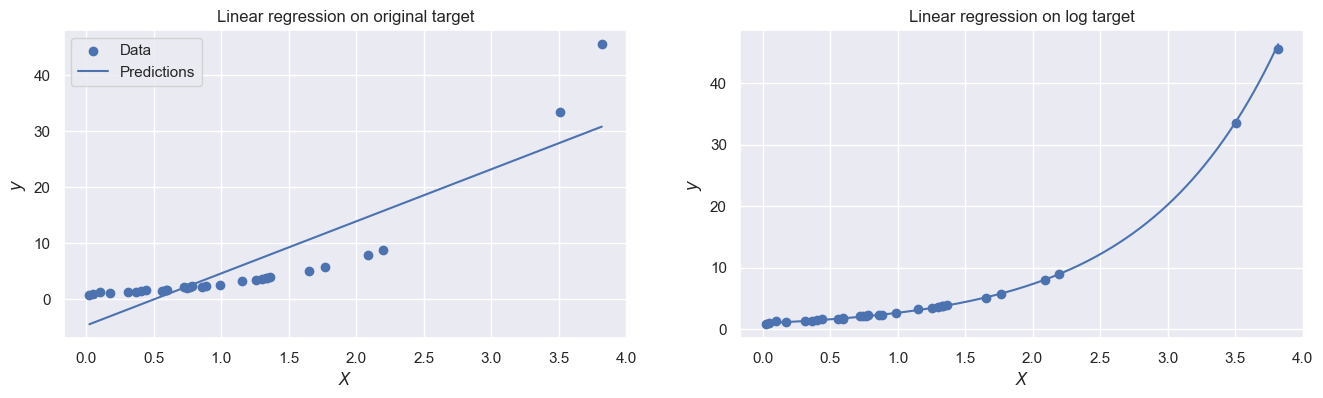

In [58]:
X = np.random.exponential(1, size=30)
y = np.exp(X) + np.random.normal(scale=0.1, size=X.shape)

x_plot = np.linspace(np.min(X), np.max(X), 10000)

fig, axs = plt.subplots(figsize=(16, 4), ncols=2)

regr = LinearRegression()
regr.fit(X[:, np.newaxis], y)
y_pred_regr = regr.predict(x_plot[:, np.newaxis])
axs[0].scatter(X[:, np.newaxis], y, label="Data")
axs[0].plot(x_plot, y_pred_regr, label="Predictions")
axs[0].legend()
axs[0].set_title("Linear regression on original target")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$y$")

y_log = np.log(y)
regr.fit(X[:, np.newaxis], y_log)
y_pred_log = np.exp(regr.predict(x_plot[:, np.newaxis]))
axs[1].scatter(X[:, np.newaxis], y, label="Data")
axs[1].plot(x_plot, y_pred_log, label="Predictions")
axs[1].set_title("Linear regression on log target")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$y$")

Но, конечно, вряд ли в реальных данных будет действительно экспоненциальная связь между целевой переменной и линейной комбинацией признаков. Тем не менее, логарифмирование всё равно может помочь.

Более интересные примеры преобразования таргета можно найти в [примере](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html) документации sklearn.